<a href="https://colab.research.google.com/github/felix-rosenberger/image-classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Username: Felix Rosenberger

# Introduction

This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Library and Data Import

In [41]:
# library import
import os
from google.colab import drive
from skimage.feature import hog, corner_harris, corner_peaks, local_binary_pattern, canny
from skimage import exposure
from scipy import ndimage as ndi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
# notebook setup
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/COMP8220/Major_Project/image-classification')

Mounted at /content/gdrive


In [3]:
# read data in
train = np.load('Data/Training_data_images.npy')
test = np.load('Data/PublicTest_data_images.npy')
labels = np.load('Data/Training_data_labels.npy')

# Basic Data Exploration

Let's first have a look at the different arrays.

In [4]:
# training data
print(f'The training data: \t{train.shape}\n'
      f'The test data: \t\t{test.shape}\n'
      f'The label data: \t{labels.shape}\n')


The training data: 	(9328, 48, 48)
The test data: 		(1136, 48, 48)
The label data: 	(9328,)



We can see that the **training data consists of 9328 images**, each of which is a 48x48 array itself. The image size represents the pixels of each image. Similarly, the test data consists of 1136 images. The label data is vector containing the labels of the 9328 training images. We'll know look at the labels in more detail.

In [5]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

The integers shown are the unique image labels which correspond to emotions displayes on the images. The above order correspond to the labels **[angry, disgusted, fearful, happy, sad, surprised, neutral]**.
Let's look at the first 6 images and corresponding labels.

In [6]:
# create label dict
keys = list(np.unique(labels))
values = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
label_classes = dict(zip(keys, values)) # provide key value pairs using zip
print(label_classes)

{0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}


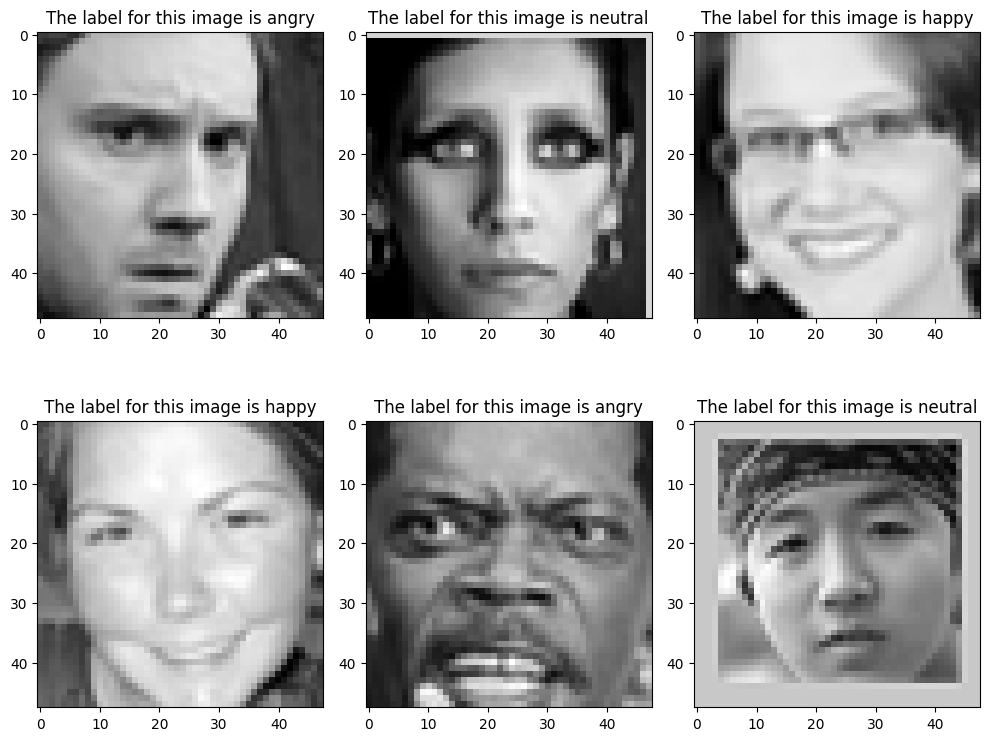

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
for i in range(len(train[0:6])):
    lookup_key = labels[i]
    subplot = ax[i // 3, i % 3] # get current subplot
    subplot.imshow(train[i], cmap='gray') # plot image on the current subplot
    subplot.set_title(f'The label for this image is {label_classes[lookup_key]}') # set title to corresponding label

plt.tight_layout() # no overlap
plt.show()

Next we'll look at the range of pixel sizes for each image.

In [8]:
# loop through all images and check min max values
n = 0
for i in range(len(train)):
  min_val = np.min(train[i])
  max_val = np.max(train[i])
  if min_val < 0 and max_val > 1:
    print('values out of normalisation range')
  else:
    n += 1

print(f'All pixel values are between 0 and 1') if n == len(train) else print(f'Pixel scales are not aligned')

All pixel values are between 0 and 1


We now know that all pixel sizes are between 0 and 1. Hence normalisation is not required at a later stage for preprocessing.

# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy x%) was an SVM with a polynomial kernel.  The features were ...

## Data Preprocessing and Feature Extraction

### Baseline
Before diving into ML models, we need to establish a baseline against complex models are evaluated, i.e., to assess whether they actually add value. The most simple approach would just be to assign classes based on their training data representation. Hence any ML model only adds value if it improves the below classification accuracies. One method could be to just predict the most frequent class which is **happy (29.33%) and use this as a benchmark**. A model has to be at least as good.

In [9]:
# get unique labels and number of occurrence
unique, counts = np.unique(labels, return_counts=True)

# calculate percentages
total_samples = len(labels)
percentages = (counts / total_samples) * 100

# map unique labels to their corresponding expression
label_names = [label_classes[label_num] for label_num in unique]

In [10]:
for label, num in zip(label_names, percentages):
  print(f'{label}: {num:.2f}%')

angry: 13.57%
disgusted: 2.26%
fearful: 11.87%
happy: 29.33%
sad: 11.18%
surprised: 11.28%
neutral: 20.51%


However, since we are dealing with imbalanced data for multiple classes, a more nuanced approach seems feasible. For this, we we will calculate the odds of guessing each class based on their frequency in the data, and calculate the expected accuracy if we would do this constantly (see: https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f).

In [11]:
sum_freq = 0
for i in percentages:
  sum_freq += (i/100)**2

print(f'If we guessed at the rate of class frequency in the training data, the accuracy would be {sum_freq:.2%}.')

If we guessed at the rate of class frequency in the training data, the accuracy would be 18.63%.


Hence any model should at least achieve an accuracy of 18.63%. However, since always predicting 'happy' would result in a 29.33% accuracy, this should be our benchmark. Next we will create some features out of the raw image data.

### Validation Set Creation
We will split the data now into train, validation, and test data. This will preserve that information from the training data gets leaked into the test data during preprocessing steps like feature scaling. Considering the amount of training data available, adding 5% to the validation set seems reasonable. Later on, generalisation will also be evaluated using cross-validation. Let's first look at the distribution of class labels in the training data.

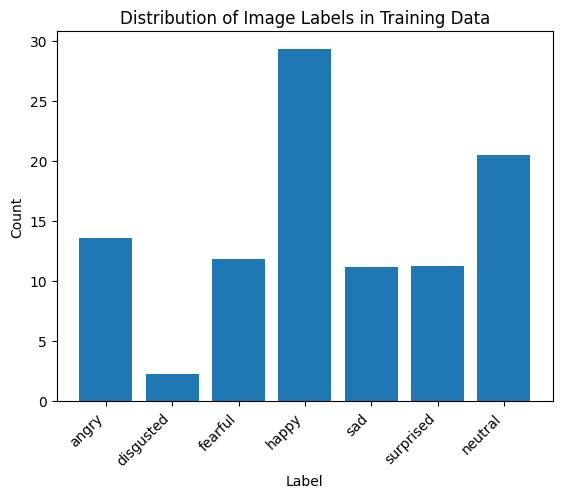

In [12]:
# get unique labels and number of occurrence
unique, counts = np.unique(labels, return_counts=True)

# calculate percentages
total_samples = len(labels)
percentages = (counts / total_samples) * 100

# map unique labels to their corresponding expression
label_names = [label_classes[label_num] for label_num in unique]

plt.bar(label_names, percentages)
plt.title("Distribution of Image Labels in Training Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show();

The plot shows that there are some expression categories which are unevelenly represented in the training data. 'happy' and 'neutral' are overrepresented while 'disgusted' is underrepresented. To split the data in a representative way, we will use the stratify argument. We will do this for each model depending on the features used.

In [13]:
# create validation set
train_data, val_data, train_labels, val_labels = train_test_split(train, labels,
                                                                  test_size=0.05, random_state=42,
                                                                  stratify=labels) # stratify based on labels proportion
# show dimensions
print(f'The training data dimensions: \t{train_data.shape}\n'
      f'The validation data dimensions: {val_data.shape}\n')

The training data dimensions: 	(8861, 48, 48)
The validation data dimensions: (467, 48, 48)



### Data Combination & Image Flattening
We'll combine train and test data before we extract any features so that all extractions will be done on both parts of the data. We will split the data again before training our ML models so that the first 9328 images are contained in the training data. After that, we'll flatten the images into feature vectors. In order to feed our data into any ML algorithm, we need to flatten the multidimensional structure into a 2D format. Hence for each picture in our sample, the 48x48 2D structure will be flattened out into a vector of 2304 pixels (48*48) which will then serve as features.

In [14]:
# combine data
full_data = np.vstack((train, test))
print(f'The full data dimensions: {full_data.shape}')

The full data dimensions: (10464, 48, 48)


In [15]:
# reshape training data
n_samples = train_data.shape[0] # length of training data
n_features = train_data.shape[1] * train_data.shape[2] # length of feature vector
train_data_flat = train_data.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape validation data
n_samples = val_data.shape[0] # length of training data
n_features = val_data.shape[1] * val_data.shape[2] # length of feature vector
val_data_flat = val_data.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape test data
n_samples = test.shape[0] # length of training data
n_features = test.shape[1] * test.shape[2] # length of feature vector
test_data_flat = test.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# show dimensions
print(f'The flattened data dimensions are \n'
      f'train: {train_data_flat.shape} \n'
      f'validation: {val_data_flat.shape} \n'
      f'test: {test_data_flat.shape} \n')

The flattened data dimensions are 
train: (8861, 2304) 
validation: (467, 2304) 
test: (1136, 2304) 



### Image Sharpening
To enable easier edge and feature detection in the images, we will apply some image sharpening.

#### Unsharp Masking
A sharpening technique that enhances edges and fine details. It is a linear image processing technique which sharpens the image. The sharp details are identified as a difference between the original image and its blurred version. These details are then scaled, and added back to the original image. For blurring, a gaussian filter is used.

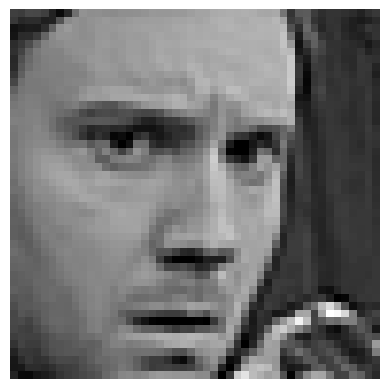

In [16]:
import cv2
import numpy as np

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, alpha=1.5, beta=-0.5):
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)

    # Calculate the unsharp mask
    mask = cv2.addWeighted(image, 1 + alpha, blurred, beta, 0)

    # Ensure pixel values are in the valid range [0, 255]
    mask = np.clip(mask / 255.0, 0, 1).astype(np.float32)

    return mask

image = train[0]

# Apply unsharp masking
sharpened_image = unsharp_mask(image, alpha=3.0, beta=-2.0)

plt.imshow(sharpened_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


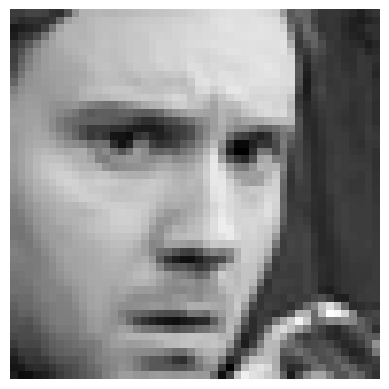

In [17]:
plt.imshow(train[0], cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [18]:
from skimage.filters import unsharp_mask

image = train[0]
result_1 = unsharp_mask(image, radius=1, # sigma for gaussian filer
                        amount=1, # amplification of filtering
                        preserve_range=True) # preserve original value range
result_2 = unsharp_mask(image, radius=5, amount=2, preserve_range=True)
result_3 = unsharp_mask(image, radius=20, amount=1, preserve_range=True)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

(48, 48)

#### High-Pass Filtering (Laplacian Sharpening)
The Laplacian filter enhances edges and is a simple yet effective sharpening method.

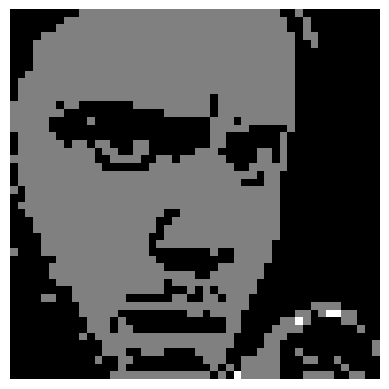

In [19]:
import cv2

def laplacian_sharpen(image):
    # Apply Laplacian filter for edge enhancement
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Convert back to uint8 and ensure pixel values are in the valid range [0, 255]
    sharpened_image = cv2.convertScaleAbs(image - laplacian)

    return sharpened_image

image = train[0]

# Apply Laplacian sharpening
sharpened_image = laplacian_sharpen(image)

plt.imshow(sharpened_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


### Data Augmentation
Considering the sample size of our training data, augmenting the images by rotating, scaling, and other approaches seems like a useful approach to increase our training data and provide more input for any ML algorithm to learn from. In addition to this, the high-dimensionality of image data will also lead to a need of as much training data as possible.

### Feature Descriptors
e.g. HOG features, HOF features or MBH features
We will create those features based on the original train data and merge them into the flattened array.


#### Histogram of Oriented Gradients (HOG)
This feature descriptor is effective for capturing the shape and texture information of objects in images. Hence this is expected to provide useful information for the detection of an emotional state.




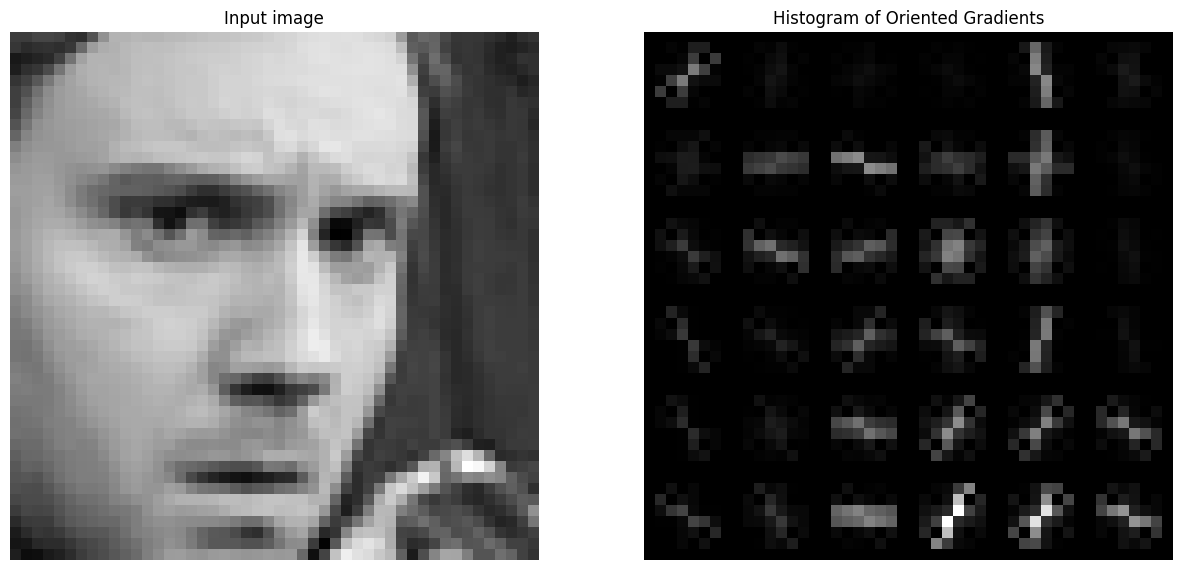

In [20]:
# show on first picture
feats, hog1 = hog(full_data[0], orientations= 8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(train[0], cmap='gray'), axes1.set_title('Input image')
axes2.axis('off'), axes2.imshow(hog1, cmap='gray'), axes2.set_title('Histogram of Oriented Gradients')
plt.show()

In [21]:
feats.shape

(288,)

Creating HOG descriptors with the above arguments would create 288 additional features for each picture. We'll create a function to extract the HOG descriptors, apply it to each picture and merge the output features with the flattened data.

In [22]:
def hog_image(image: np.array):
    """Apply Histogram of Oriented Gradients (HOG) and return the image as a flattened vector."""
    features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=False)
    return features

In [23]:
# extract HOG features for each image in training data
hog_features = [hog_image(image) for image in train_data]
hog_features_array = np.array(hog_features) # convert to array
train_hog = np.hstack((train_data_flat, hog_features_array)) # merge into other data

# extract HOG features for each image in validation data
hog_features = [hog_image(image) for image in val_data]
hog_features_array = np.array(hog_features) # convert to array
val_hog = np.hstack((val_data_flat, hog_features_array)) # merge into other data

# extract HOG features for each image in test data
hog_features = [hog_image(image) for image in test]
hog_features_array = np.array(hog_features) # convert to array
test_hog = np.hstack((test_data_flat, hog_features_array)) # merge into other data

In [24]:
# show dimensions
print(f'The data dimensions incl. HOG features are \n'
      f'train: \t\t{train_hog.shape} \n'
      f'validation: \t{val_hog.shape} \n'
      f'test: \t\t{test_hog.shape} \n')

The data dimensions incl. HOG features are 
train: 		(8861, 2592) 
validation: 	(467, 2592) 
test: 		(1136, 2592) 



We can see above that the 288 HOG features have been added to the raw data.

#### Harris Corner Detector
This descriptor identifies points in an image where the intensity or color changes significantly in multiple directions, indicating the presence of corners, junctions, or key features/objects. Different emotions might manifest as distinct patterns of facial features in different regions of the face which should then be detected in similar regions across images for the same emotions.





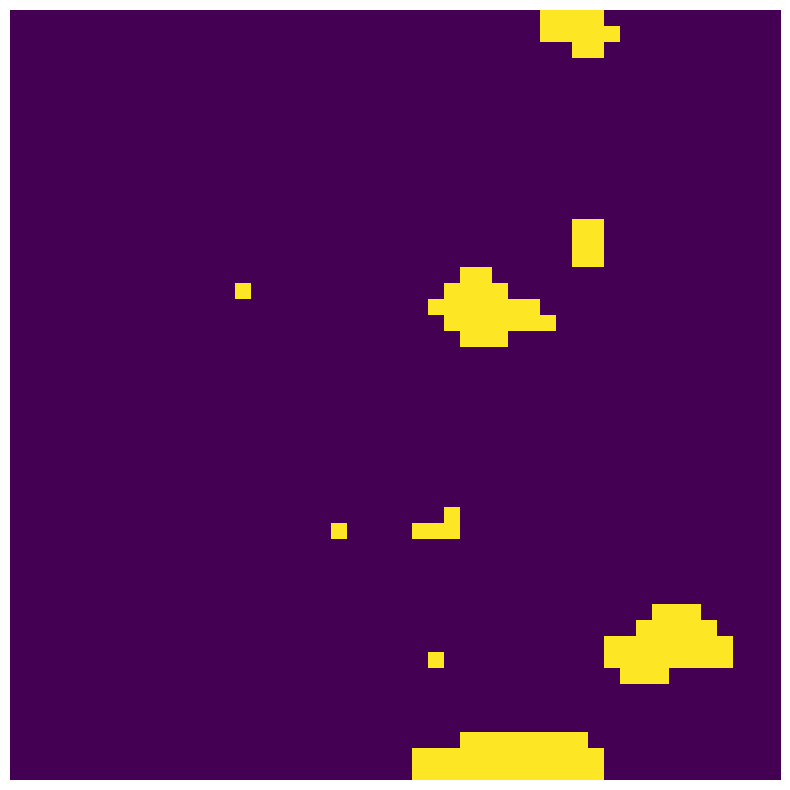

In [25]:
# show corners for first picture
coordinates = corner_harris(full_data[0], k=0.001) # compute harris corner
corner_mask = coordinates > 0.1 * coordinates.max() # set condition mask for corner candidates
marked_image = np.copy(full_data[0]) # copy image before color set
marked_image[corner_mask] = 255

# display the marked image
plt.figure(figsize=(20, 10))
plt.imshow(marked_image)
plt.axis('off')
plt.show()

In [26]:
# show how many corners there are in the picture given a minimum distance constraint
corner_coordinates = corner_peaks(coordinates, min_distance=2)
corner_coordinates.shape

(14, 2)

We will now apply the Harris Corner Detector on all images in our training data. However, each picture will likely return a different number of corners which would be difficult to incorporate into the training data. Hence we will partition each image into a grid and count the number of corners in each region of the grid for each image which will give us a fixed sized number of features with counts for each image. This can then be used as ML input as the difference of corner occurrences in each image region will be measurable across images.

In [27]:
def harris_corners(image: np.array, num_regions_x: int, num_regions_y: int):
    """
    Apply Harris Corner Detector and return the corners as well as region-based corner counts.
    """
    coordinates = corner_harris(image, k=0.001) # harris corners
    corners = corner_peaks(coordinates, min_distance=1)
    region_counts = np.zeros((num_regions_x, num_regions_y), dtype=int) # empty array to populate

    # calculate region size
    region_height = image.shape[0] // num_regions_x
    region_width = image.shape[1] // num_regions_y

    # count corners in each region
    for corner in corners:
        region_x = min(corner[0] // region_height, num_regions_x - 1)
        region_y = min(corner[1] // region_width, num_regions_y - 1)
        region_counts[region_x, region_y] += 1 # increase count in respective region

    return region_counts

In [28]:
# apply harris corner extraction on training data
region_train = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in train_data]
region_train_flat = [array.flatten() for array in region_train] # flatten arrays into vectors
region_train_flat_np = np.array(region_train_flat) # convert to numpy

# apply harris corner extraction on validation data
region_val = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in val_data]
region_val_flat = [array.flatten() for array in region_val] # flatten arrays into vectors
region_val_flat_np = np.array(region_val_flat) # convert to numpy

# apply harris corner extraction on test data
region_test = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in test]
region_test_flat = [array.flatten() for array in region_test] # flatten arrays into vectors
region_test_flat_np = np.array(region_test_flat) # convert to numpy

In [29]:
# apply scaling on individual datasets
scaler = MinMaxScaler()
norm_regions_train = scaler.fit_transform(region_train_flat_np) # fit scaling parameters on training data
norm_regions_val = scaler.transform(region_val_flat_np) # transform validation data
norm_regions_test = scaler.transform(region_test_flat_np) # transform test data

# merge corner features with other data respectively
train_hog_corner = np.hstack((train_hog, norm_regions_train))
val_hog_corner = np.hstack((val_hog, norm_regions_val))
test_hog_corner = np.hstack((test_hog, norm_regions_test))

In [30]:
# show dimensions
print(f'The data dimensions incl. HOG & corner features are \n'
      f'train: \t\t{train_hog_corner.shape} \n'
      f'validation:\t {val_hog_corner.shape} \n'
      f'test: \t\t{test_hog_corner.shape} \n')

The data dimensions incl. HOG & corner features are 
train: 		(8861, 2608) 
validation:	 (467, 2608) 
test: 		(1136, 2608) 



The Harris Corner features have been added. Basically, there are now 16 additional features for each image which show a distribution of corner counts for the same subregions of all images. Since these corners are relevant points in an image, they are expected to help a ML classifier identifying similar emotions across different images.

#### Local Binary Patterns (LBP)
The goal of LBP is to encode geometric features of an image by detecting edges, corners, raised or flat areas and hard lines. This allows us to generate a feature vector representation of an image through density function representations which can then be used as input for ML models.
In this case, we will use a uniform method to preserve rotation invariance. First, we extract the binary patterns for each image. Second, we calculate the histogram of LBP values for each image. Third, we normalize these values and, fourth, concatenate these into a vector of feature per image which can then be concatenated to the full data.

In [31]:
def lbp_extraction(image_data: np.array, radius: int, neighbors: int, method='uniform'):

  lbp_histograms = [] # empty list to store histograms

  # apply binary pattern extraction and histogram for each image
  n_points = neighbors * radius
  for image in image_data:
    # get pattern
    binary_image_pattern = local_binary_pattern(image, method=method, R=radius, P=n_points)

    # get histogram
    n_bins = int(binary_image_pattern.max() + 1) # number of bins
    hist, _ = np.histogram(binary_image_pattern.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_histograms.append(hist) # append to list

  return lbp_histograms

Now we can apply the above function which does the job for tasks 1 and 2 outlined before. Then we will standardize the outputs on train, validation, and test set separately.

In [32]:
# extract LBP patterns and histograms on training data
lbp_train = lbp_extraction(train_data, radius=1, neighbors=8)

# extract LBP patterns and histograms on validation data
lbp_val = lbp_extraction(val_data, radius=1, neighbors=8)

# extract LBP patterns and histograms on test data
lbp_test = lbp_extraction(test, radius=1, neighbors=8)

In [33]:
# apply scaling on individual datasets
scaler = MinMaxScaler()
norm_lbp_train = scaler.fit_transform(lbp_train) # fit scaling parameters on training data
norm_lbp_val = scaler.transform(lbp_val) # transform validation data
norm_lbp_test = scaler.transform(lbp_test) # transform test data

# merge corner features with other data respectively
train_hog_corner_lbp = np.hstack((train_hog_corner, norm_lbp_train))
val_hog_corner_lbp = np.hstack((val_hog_corner, norm_lbp_val))
test_hog_corner_lbp = np.hstack((test_hog_corner, norm_lbp_test))

In [34]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{train_hog_corner_lbp.shape} \n'
      f'validation: \t{val_hog_corner_lbp.shape} \n'
      f'test: \t\t{test_hog_corner_lbp.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(8861, 2618) 
validation: 	(467, 2618) 
test: 		(1136, 2618) 



#### Canny Edge Detector
We will use the Canny edge detection algorithm as it produces smoother, thinner, and cleaner images than Sobel and Prewitt filters.



We will try different parameter specifications including gaussian blurring as a first step on the first image of the training data to get a feeling for reasonable parameter values edge detection. Then we will apply it on our whole data.



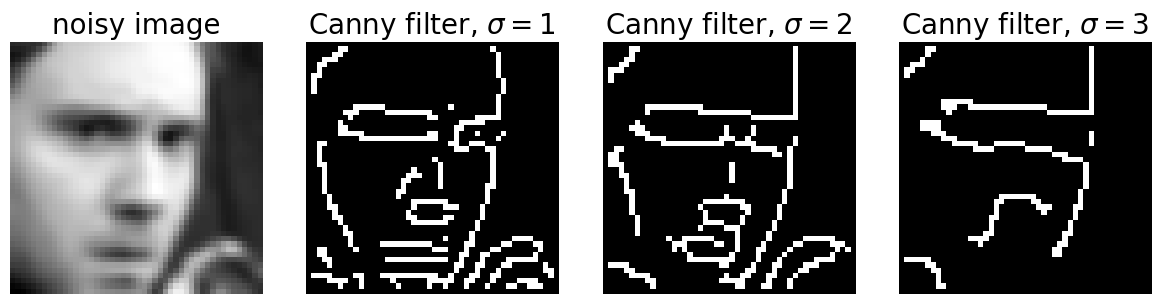

In [ ]:
# apply gaussian blur
image = ndi.gaussian_filter(train[0], sigma=1)

# compute canny filter for two values of sigma
edges1 = canny(image, sigma=1)
edges2 = canny(image, sigma=2)
edges3 = canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

ax[0].imshow(image, cmap='gray') # blurred image
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

ax[3].imshow(edges3, cmap='gray')
ax[3].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

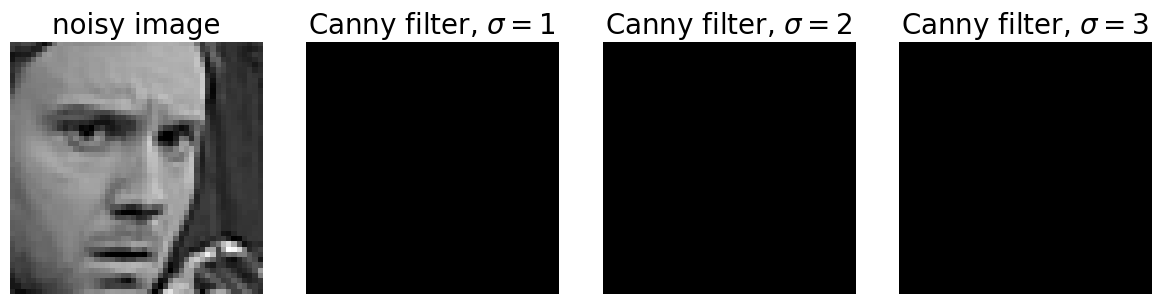

In [ ]:

# apply gaussian blur
#image = ndi.gaussian_filter(sharpened_image, sigma=1)
image = sharpened_image

# compute canny filter for two values of sigma
edges1 = canny(image, sigma=1)
edges2 = canny(image, sigma=2)
edges3 = canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

ax[0].imshow(image, cmap='gray') # blurred image
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

ax[3].imshow(edges3, cmap='gray')
ax[3].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Different parameter variations have been tried, including incorporation of random noise in addition to gaussian blur. In the end, both a gaussian blur and the canny filter with σ=1 seemed like the most reasonable parameter choice as the edges showed the main characteristics of the corresponding emotion the most. Now we will apply the edge detection on all images.

In [ ]:
def edge_detection(images: np.array, sigma_gauss: float, sigma_canny: float):
  """
  This function applies edge detection on images in an array of images and returns
  a binary feature vector of 0 and 1 determining where edges are present or not.
  """
  edges = [] # empty list to append edge vectors to

  for image in images: # get index and image
    blurred = ndi.gaussian_filter(image, sigma=1) # apply gaussian blur
    edged = canny(blurred, sigma=1) # apply edge detection
    edged_flat = edged.flatten()
    edged_binary = edged_flat.astype(int) # transform true/false to 1/0
    edges.append(edged_binary) # append edge vector

  edges = np.array(edges) # transform to numpy array

  return edges

In [ ]:
# apply edge detection on training data
edge_train = edge_detection(train_data, sigma_gauss=1, sigma_canny=1)

# apply edge detection on validation data
edge_val = edge_detection(val_data, sigma_gauss=1, sigma_canny=1)

# apply edge detection on test data
edge_test = edge_detection(test, sigma_gauss=1, sigma_canny=1)

In [ ]:
# merge corner features with other data respectively
train_hog_corner_lbp_canny = np.hstack((train_hog_corner_lbp, edge_train))
val_hog_corner_lbp_canny = np.hstack((val_hog_corner_lbp, edge_val))
test_hog_corner_lbp_canny = np.hstack((test_hog_corner_lbp, edge_test))

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{train_hog_corner_lbp_canny.shape} \n'
      f'validation: \t{val_hog_corner_lbp_canny.shape} \n'
      f'test: \t\t{test_hog_corner_lbp_canny.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(8861, 4922) 
validation: 	(467, 4922) 
test: 		(1136, 4922) 



## Raw Data ML Model

### Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf, train_data_flat, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf.fit(train_data_flat, train_labels) # fit classifier on full data again
y_pred = svm_clf.predict(val_data_flat) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.5036661  0.50677201 0.51297968 0.50282167 0.51354402]
Average Cross-Validation Accuracy: 		50.80%
Cross-Validation Accuracy Standard Deviation: 	0.45%
Final Accuracy on Validation Data: 		54.39%


In [ ]:
# predict on test data
y_pred_test = svm_clf.predict(test_data_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,9.0,4.57
disgusted,2.26,0.0,2.26
fearful,11.87,5.0,6.87
happy,29.33,39.0,-9.67
sad,11.18,2.0,9.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


The first SVM classifier using only the raw data already improved the initially estimated baseline by a lot. It is interesting to see that **this model did not predict 'disgusted' (1) for any picture**. This happens to be the most underrepresented class in the training data so it seems like SVM had trouble learning about this emotion particularly. Contrarily, **the most frequent classes prevalent in the training data are heavily overrepresented in the actual predictions**. This partly explains the overall low accuracy of roughly 50%. The model did not pick up important nuances
Now we will try further improvements using different models and engineered features. The above obviously only applies under the assumptions that the test data is distributed similarly to the training data.

## LBP Pattern ML Model
Let's try to use only the LBP patterns as model input to see how it compares to using only the raw data.

### Support Vector Machine

In [ ]:
svm_lbp = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_lbp, norm_lbp_train, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_lbp.fit(norm_lbp_train, train_labels) # fit classifier on full data again
y_pred = svm_lbp.predict(norm_lbp_val) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.32036097 0.32731377 0.32505643 0.3278781  0.31941309]
Average Cross-Validation Accuracy: 		32.40%
Cross-Validation Accuracy Standard Deviation: 	0.35%
Final Accuracy on Validation Data: 		34.05%


This model clearly lacks predictive power as its accuracy is significantly worse compared to using raw data only. Further, it is only slightly above our estasblished baseline of using the most frequent emotion as a single prediction for all images. Thus, it seems like the raw data is needed in addition.

## Raw Data + HOG ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog, train_hog, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog.fit(train_hog, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog.predict(val_hog) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.5284828  0.52934537 0.53611738 0.53273138 0.54288939]
Average Cross-Validation Accuracy: 		53.39%
Cross-Validation Accuracy Standard Deviation: 	0.52%
Final Accuracy on Validation Data: 		57.17%


In [ ]:
# predict on test data
y_pred_test = svm_clf_hog.predict(test_hog)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


## Raw Data + HOG + Harris Corner ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog_corner = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog_corner, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog_corner.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog_corner.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.52791878 0.53160271 0.53724605 0.53329571 0.54232506]
Average Cross-Validation Accuracy: 		53.45%
Cross-Validation Accuracy Standard Deviation: 	0.49%
Final Accuracy on Validation Data: 		56.96%


In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


#### Hyperparameter Tuning
To conduct hyperparameter tuning on the SVM model, we will use a randomized grid search approach to reduce the required number of combinations for model computation. Specifically for SVM, the regularisation parameter C, the kernel to use, and the kernel coefficient gamma are the parameters of interest.

In [ ]:
def get_params(model, X_train, y_train, param_grid):
    """
    This function applies randomized grid search for hyperparameter tuning on a given estimator and returns
    the best score in combination with the according parameters used.
    """
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                     scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    best_score = grid_search.best_score_ # retrieve best score
    best_params = grid_search.best_params_ # retrieve best parameters
    final_model = grid_search.best_estimator_

    return best_score, best_params, final_model

In [ ]:
# define parameter grid
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 5],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 5]
    }

# define model
svm_hog_cor_hp = SVC(random_state=42)

In [ ]:
# apply grid search
best_score, best_params, final_model = get_params(model=svm_hog_cor_hp, X_train=train_hog_corner, y_train=train_labels, param_grid=param_grid)

In [ ]:
print(f'The best model parameters are: \t\t{best_params}\n'
      f'The highest accuract from cross-validation is: \t{best_score:.2%}\n')

The best model parameters are: 		{'kernel': 'poly', 'gamma': 0.01, 'C': 0.01}
The highest accuract from cross-validation is: 	55.25%



Let's now test this parameter-optimized model on the test data.

In [ ]:
# predict on test data
y_pred_test = final_model.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner-paramopti.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,11.0,2.57
disgusted,2.26,1.0,1.26
fearful,11.87,7.0,4.87
happy,29.33,34.0,-4.67
sad,11.18,5.0,6.18
surprised,11.28,10.0,1.28
neutral,20.51,33.0,-12.49


It is interesting to see that this is the first model that also included predictions from the emotion 'disgusted'. While we cannot evaluate if these are correctly predicted simply from looking at the overall accuracy, it can be noted that the CV accuracy improved compared to the previous SVM model. Also this is the model which achieved the best test data accuracy so far with 55.9%.

### Naive Bayes

### Ensemble Methods

#### Random Forest

In [ ]:
# initialise instance
rf_clf_hog_cor = RandomForestClassifier(n_estimators = 100, criterion='entropy', min_samples_split=3, max_features='sqrt',
                                        bootstrap=True, max_leaf_nodes = 16, n_jobs = -1, random_state = 42,
                                        class_weight=None, max_samples=None)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(rf_clf_hog_cor, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
rf_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = rf_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.3857868  0.4006772  0.39390519 0.38713318 0.39164786]
Average Cross-Validation Accuracy: 		39.18%
Cross-Validation Accuracy Standard Deviation: 	0.53%
Final Accuracy on Validation Data: 		39.19%


It seems like the random forest algorithm is not well suited for detecting facial emotions from the input data given.

#### AdaBoost

In [38]:
ada_clf_hog_cor = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth = 1), # decision stumps
                                    n_estimators = 200,
                                    algorithm = "SAMME.R", # real boosting algorithm
                                    learning_rate = 0.5, # lower learning rate to support generalization through shrinkage
                                    random_state = 42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(ada_clf_hog_cor, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
ada_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = ada_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [39]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.45685279 0.4486456  0.4503386  0.46557562 0.45316027]
Average Cross-Validation Accuracy: 		45.49%
Cross-Validation Accuracy Standard Deviation: 	0.60%
Final Accuracy on Validation Data: 		50.75%


Again, on its own, AdaBoost does not seem to be a promising model.

#### XGBoost
There are a few important hyperparameters to consider for XGBoost:


1.   `'learning_rate'`: How fast the learning occurs; default=0.3.
2.   `'gamma'`: Minimum loss reduction required to make a further partition on a leaf node of the tree. Larger gamma = more conservative; default=0.
3.    `'max_depth'`: Maximum depth of a tree. Larger value = more complex, more likely to overfit; default=6.
4.    `'subsample'`: Subsample ratio of the training instances; default=1 -> whole data. Regulate model complexity for overfitting.
5.    `'eval_metric'`:
6.    `'reg_alpha'`: L1 regularization term on weights.
7.    `'reg_lambda'`: L2 regularization term on weights.
8.    `'num_round'`: More rounds for smaller learning rate.
9.    `'colsample_bytree'`: Subsample ratio of columns for tree construction.
10.   `'scale_pos_weight'`: Useful for class imbalances e.g. `sum(negative instances) / sum(positive instances)`
11.   `'objective'`: `multi:softmax` for multiclass classification --> needs `num_class` in conjunction.
12.   `'eval_metric'`: `merror` and `mlogloss` reasonable


In [46]:
xgb_clf_hog_cor = xgb.XGBClassifier()
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
#scores = cross_val_score(xgb_clf_hog_cor, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
xgb_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = xgb_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [47]:
# print cross-validation scores and final accuracy
# print(f'Cross-Validation Scores: \t\t\t{scores}')
# print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
# print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Final Accuracy on Validation Data: 		60.81%


In [48]:
# predict on test data
y_pred_test = xgb_clf_hog_cor.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [49]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,1.0,1.26
fearful,11.87,8.0,3.87
happy,29.33,35.0,-5.67
sad,11.18,7.0,4.18
surprised,11.28,10.0,1.28
neutral,20.51,30.0,-9.49


Just the default XGBoost model on this input data combination looks already more promising than the hyperparameter tuned SVM. On the test data, this model achieved an accuracy of 59.07%.

#### Stacking
Another approach is to leverage the capabilities of several models through stacking. We will employ different ensemble methods for model training and then use their validation set predictions as input for a final meta-model.
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28

## Raw Data + HOG + Harris Corner + LBP ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog_corner_lbp = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog_corner_lbp, train_hog_corner_lbp, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog_corner_lbp.fit(train_hog_corner_lbp, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog_corner_lbp.predict(val_hog_corner_lbp) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.52791878 0.53160271 0.53837472 0.53216704 0.53950339]
Average Cross-Validation Accuracy: 		53.39%
Cross-Validation Accuracy Standard Deviation: 	0.44%
Final Accuracy on Validation Data: 		56.96%


The addition of LBP did not improve the SVM model.

In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner_lbp.predict(test_hog_corner_lbp)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner-lbp.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


#### Hyperparameter Tuning
To conduct hyperparameter tuning on the SVM model, we will use a randomized grid search approach to reduce the required number of combinations for model computation. Specifically for SVM, the regularisation parameter C, the kernel to use, and the kernel coefficient gamma are the parameters of interest.

In [ ]:
def get_params(model, X_train, y_train, X_val, y_val, X_test, param_grid):
    """
    This function applies randomized grid search for hyperparameter tuning on a given estimator and returns
    the best score in combination with the according parameters used.
    """
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                     scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    best_score = grid_search.best_score_ # retrieve best score
    best_params = grid_search.best_params_ # retrieve best parameters
    y_pred = grid_search.predict(X_val) # predict on validation data
    pred_accuracy = accuracy_score(y_val, y_pred) # calculate accuracy on validation data
    test_pred = grid_search.predict(X_test)

    return best_score, best_params, pred_accuracy

In [ ]:
# define parameter grid
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    }

# define model
svm_hog_cor_lbp_hp = SVC(random_state=42)

In [ ]:
# apply grid search
best_score, best_params, pred_accuracy = get_params(model=svm_hog_cor_lbp_hp, X_train=X_train, y_train=y_train,
                                                    X_val=X_val, y_val=y_val, X_test=X_test, param_grid=param_grid)

In [ ]:
print(f'The best model parameters are: \t\t{best_params}\n'
      f'The highest accuract from cross-validation is: \t{best_score}\n'
      f'The accuracy on the validation data is: \t{pred_accuracy}')

Let's now test this parameter-optimized model on the test data.

In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner.predict(test_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


### Random Forest

### Naive Bayes

### XGBoost

### AdaBoost

# Discussion on Conventional ML Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a logistic regression model, ...  This performed fairly poorly (accuracy y%) ...  This may have been because ...

# Deep Learning Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy (x+5)%) was a fully connected dense model with NN layers.  The input was the raw data that had been preprocessed by ...

### Baseline Model
We will build a Neural Net with a simple architecture first. This will act as a baseline for more complex architectures to be evaluated against that baseline.

## Data Preprocessing
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

https://prince-canuma.medium.com/image-pre-processing-c1aec0be3edf

https://www.kaggle.com/code/khotijahs1/cv-image-preprocessing

https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

### Data Augmentation
https://www.section.io/engineering-education/image-preprocessing-in-python/

## Regularisation
e.g. Monte Carlo Droput

[Following this, code and comments as above.]

# Discussion on Deep Learning Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a CNN with two conv layers and ...  This performed almost as well as the final model (accuracy (x-3)%) ...  This gap in performance may have been because ...

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 5% on the public test set.  The deep learning model ranked #12 out of N submissions on the public test set, with the top-performing system having z% accuracy, and a majority class baseline having z'% accuracy ...

[E.g. discussion about what performance on validation set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what performance on private test set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what inspecting the data might say about your models or about the dataset.]

[E.g. reflection on resource required for models or other implementation issues.]

